In [2]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

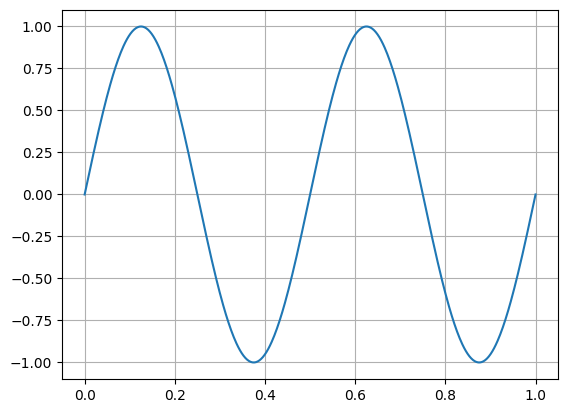

In [28]:
x = torch.linspace(0, 1, 512)
u = torch.sin(4*torch.pi * x)

plt.plot(x, u)
plt.grid()
plt.show()

In [29]:
from pinns.samplers import ConstantSampler, RandomRectangularSampler

pts = torch.tensor([x[0], x[-1]]).reshape(-1, 1)
vals = torch.tensor([u[0], u[-1]]).reshape(-1, 1)
constraints_sampler = ConstantSampler((pts, vals))

domain = {'x': [0, 1]}
collocation_sampler = RandomRectangularSampler(domain, 256, return_dict=False)

test_points_sampler = ConstantSampler((
    x.reshape(-1, 1), u.reshape(-1, 1)
))

In [30]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred
    ):
    
    def boundary_loss(u, x):
        return torch.mean(torch.square(u - cstr_vals))

    def ode_loss(u, x):
        uxx = d(u, x, orders = 2)
        return torch.mean(torch.square(uxx + 16*torch.pi**2 * torch.sin(4*torch.pi*x)))
    
    losses = (
        boundary_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [31]:
def get_dists(pts, B = 1):
    left_dists  = pts[:,0]
    right_dists = (pts[:,0] - B).abs()
    dists = torch.stack([left_dists, right_dists]).T
    return dists.min(dim=1).values

ip_pts, ip_vals = test_points_sampler()
dists = get_dists(ip_pts)

In [35]:
from pinns import Trainer
from pinns.models import FF
from pinns.optimizers import Adam
from pinns.metrics import l2

pinn = FF([1] + [64] + [1], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],
)

num_iters = 1500

errors = []
def save_error():
    if trainer.iter == 0 or (trainer.iter + 1) % 5 == 0:
        preds = pinn(ip_pts).detach()
        error = (preds - ip_vals).abs().flatten()
        errors.append(error)

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics=[l2],
    test_sampler = test_points_sampler,
    training_start_callbacks=[save_error],
    epoch_end_callbacks=[save_error],
    )

Model has {'total': 193, 'trainable': 193} trainable parameters.


  0%|          | 0/1500 [00:00<?, ?it/s]

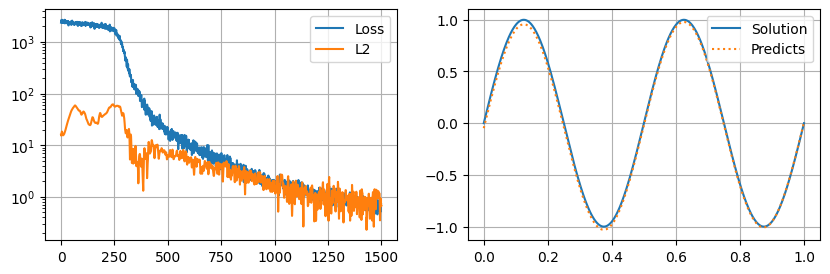

In [36]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='L2')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(x.reshape(-1, 1))
axs[1].plot(x, u, label='Solution')
axs[1].plot(x, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

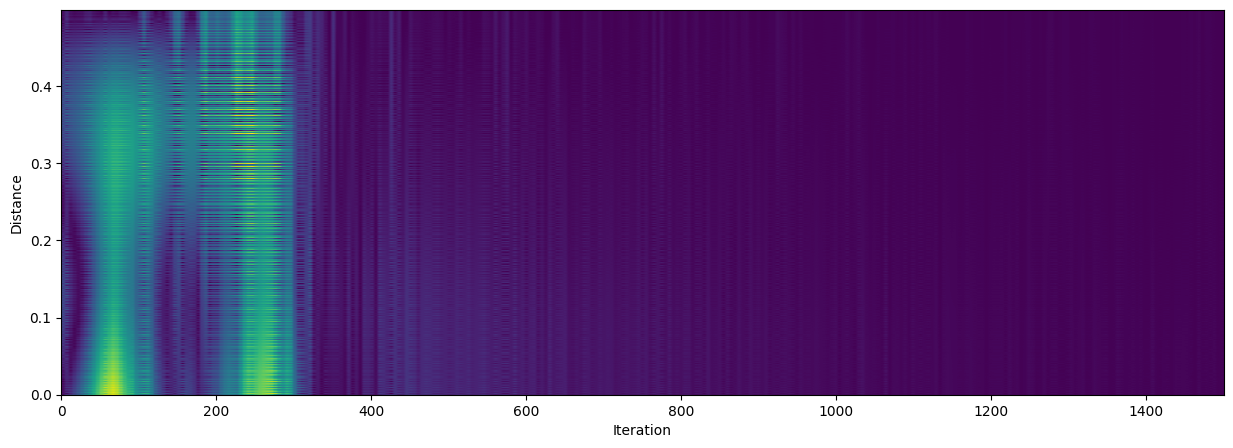

In [37]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 0].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()